In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.random.seed(167)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #elif 'datetime' not in col_type.name:
        #    df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 1. Load data and Features engineering

In [3]:
train = pd.read_csv('train_v2.csv')

In [4]:
test = pd.read_csv('sample_submission_v2.csv')

In [5]:
msno_train = train['msno'].tolist()
msno_test = test['msno'].tolist()
msno_all = list(set(msno_train).union(set(msno_test)))
msno_inter = list(set(msno_train).intersection(set(msno_test)))

### 1.1. `user_logs` dataset

In [6]:
def user_preprocess(df):
    df = df.loc[df['msno'].isin(msno_all)]
    df = reduce_mem_usage(df)
    df = df.groupby('msno').agg({'msno': 'count',
                                 'date': 'min',
                                 'num_25': 'sum',
                                 'num_50': 'sum',
                                 'num_75': 'sum',
                                 'num_985': 'sum',
                                 'num_100': 'sum',
                                 'num_unq': 'sum', 
                                 'total_secs': 'sum'})
    df = df.rename(columns = {'msno': 'count'}).reset_index()  
    return df

In [7]:
reader = pd.read_csv('user_logs.csv', chunksize=40000000)
user_data = pd.DataFrame()
for chunk in tqdm(reader):
    chunk = user_preprocess(chunk)
    user_data = pd.concat([user_data, chunk])
del chunk

0it [00:00, ?it/s]D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [8]:
user_logs = pd.read_csv('user_logs_v2.csv')
user_logs = user_preprocess(user_logs)
user_data = pd.concat([user_data, user_logs])
del user_logs

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [9]:
user_data = user_data.groupby('msno').agg({'count': 'sum',
                                           'date': 'min',
                                           'num_25': 'sum',
                                           'num_50': 'sum',
                                           'num_75': 'sum',
                                           'num_985': 'sum',
                                           'num_100': 'sum',
                                           'num_unq': 'sum', 
                                           'total_secs': 'sum'})

In [10]:
user_data = user_data.reset_index()
user_data['date'] = pd.to_datetime(user_data['date'], format='%Y%m%d')
user_data['year_start'] = user_data['date'].dt.year
user_data = user_data.drop('date', axis = 1)

In [11]:
cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
for col in cols:
    user_data[col] = user_data[col]/user_data['count']

In [12]:
train = pd.merge(train, user_data, on = 'msno', how = 'left')
test = pd.merge(test, user_data, on = 'msno', how = 'left')

In [13]:
del user_data

### 1.2. `members_v3.csv` dataset

In [14]:
members = pd.read_csv('members_v3.csv')
members = members.loc[members['msno'].isin(msno_all)] 
train = pd.merge(train, members, how = 'left', on = 'msno')
test = pd.merge(test, members, how = 'left', on = 'msno')
del members

In [15]:
def members_preprocess(df):
    df['city'] = df['city'].fillna(0)
    df['city'] = df['city'].apply(lambda x: 1 if ((x == 0) | (x == 1)) else 0)
    df['gender'] = df['gender'].fillna('unknown')
    df['registered_via'] = df['registered_via'].fillna(0)
    df['registered_via'] = df['registered_via'].apply(lambda x: 0 if ((x == 0) | (x == 7)) else (2 if x == 4 else 1))
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d')
    df['registration_year'] = df['registration_init_time'].dt.year
    df = df.drop(['bd', 'registration_init_time'], axis = 1)
    return df

In [16]:
train = members_preprocess(train)
test = members_preprocess(test)

### 1.3. `transactions.csv` and `transactions_v2.csv` dataset

In [17]:
transactions = pd.concat([pd.read_csv('transactions.csv'), pd.read_csv('transactions_v2.csv')], axis = 0)
transactions = reduce_mem_usage(transactions)
transactions = transactions.loc[transactions['msno'].isin(msno_all)] 
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
transactions = transactions.sort_values(by = ['msno', 'transaction_date'], ascending = [True, True])
train_transactions = transactions.loc[transactions['msno'].isin(msno_train)]
test_transactions = transactions.loc[transactions['msno'].isin(msno_test)]
del transactions

In [18]:
def transaction_features(transactions, df, is_train = True):
    check1 = transactions.groupby('msno')['transaction_date', 'membership_expire_date', 'is_cancel'].nth(-1)
    if is_train == True:
        check2 = transactions.loc[transactions['membership_expire_date'] <= pd.Timestamp('2017-03-31'), ['msno', 'transaction_date', 'membership_expire_date', 'is_cancel']]
    else:
        check2 = transactions.loc[transactions['membership_expire_date'] <= pd.Timestamp('2017-04-30'), ['msno', 'transaction_date', 'membership_expire_date', 'is_cancel']]
    check3 = check2.groupby('msno')['membership_expire_date'].max()
    check4 = check1.loc[check1['membership_expire_date'] != check3]
    check5 = check1.loc[check1['membership_expire_date'] == check3]
    case2 = check5.loc[check5['is_cancel'] == 0].index.tolist()
    case3 = check4.loc[(check4['transaction_date'] < check3.loc[check4.index]) & (check4['is_cancel'] == 0)].index.tolist()
    case4 = check4.loc[(check4['transaction_date'] >= check3.loc[check4.index]) & (check4['is_cancel'] == 0)].index.tolist()
    del check1, check2, check3, check4, check5
    df['transaction_proba'] = 0.85
    df.loc[df['msno'].isin(case2), 'transaction_proba'] = 0.6
    df.loc[df['msno'].isin(case3), 'transaction_proba'] = 0.25
    df.loc[train['msno'].isin(case4), 'transaction_proba'] = 0.02
    return df

In [19]:
train = transaction_features(train_transactions, train, is_train = True)
test = transaction_features(test_transactions, test, is_train = False)

In [20]:
def transactions_preprocess(transactions, df):
    transactions['membership_duration'] = ((transactions['membership_expire_date'] - transactions['transaction_date'])/np.timedelta64(1, 'D')).astype(int)
    transactions.loc[transactions['membership_duration'] < 0, 'membership_duration'] = 0
    transactions['discount'] = (transactions['plan_list_price'] - transactions['actual_amount_paid']).apply(lambda x: 1 if x > 0 else 0)
    transactions['time_interrupt'] = transactions.groupby('msno')['transaction_date'].diff()/np.timedelta64(1, 'D')
    sum_up = transactions.groupby('msno').agg({'payment_method_id': lambda x: x.mode().iloc[0], 
                                               'payment_plan_days': np.median,
                                               'is_cancel': np.max,
                                               'discount': np.max,
                                               'actual_amount_paid': np.mean, 
                                               'membership_duration': lambda x: x.mode().iloc[0],
                                               'time_interrupt': np.median,
                                               'transaction_date': 'first'})
    sum_up['time_interrupt'] = sum_up['time_interrupt'].fillna(0)
    sum_up['payment_method_id'] = sum_up['payment_method_id'].apply(lambda x: 1 if x == 41 else 0)
    sum_up['transaction_date'] = sum_up['transaction_date'].dt.year
    df = pd.merge(df, sum_up.reset_index(), on = 'msno')
    del transactions, sum_up
    return reduce_mem_usage(df)

In [21]:
train = transactions_preprocess(train_transactions, train)
test = transactions_preprocess(test_transactions, test)

In [22]:
del train_transactions, test_transactions

In [23]:
train.loc[train['registration_year'].isnull(), 'registration_year'] = train.loc[train['registration_year'].isnull(), 'transaction_date']
train.loc[train['year_start'].isnull(), 'year_start'] = train.loc[train['year_start'].isnull(), 'transaction_date']

In [24]:
test.loc[test['registration_year'].isnull(), 'registration_year'] = test.loc[test['registration_year'].isnull(), 'transaction_date']
test.loc[test['year_start'].isnull(), 'year_start'] = test.loc[test['year_start'].isnull(), 'transaction_date']

In [25]:
def imputer(df):
    nb_null = df.isnull().any(axis=1).sum()
    idx = np.random.permutation(df.loc[~df.isnull().any(axis = 1)].index)[:nb_null]
    df.loc[df.isnull().any(axis = 1)] = df.loc[idx].values
    return df

In [26]:
cols = ['count', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
train.loc[:, cols] = imputer(train.loc[:, cols])
test.loc[:, cols] = imputer(test.loc[:, cols])

In [27]:
cols = ['count', 'year_start', 'registration_year', 'payment_plan_days', 'time_interrupt']
train[cols] = train[cols].astype(int)
test[cols] = test[cols].astype(int)

In [28]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [29]:
train.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registration_year,transaction_proba,payment_method_id,payment_plan_days,is_cancel,discount,actual_amount_paid,membership_duration,time_interrupt,transaction_date
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,64,8.640625,1.671875,0.890625,1.437500,31.734375,12.156250,7513.968262,...,2013,0.600098,0,0,1,0,149.000,30,31,2015
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,80,1.837891,0.562500,0.287598,0.312500,10.101562,9.164062,2712.790527,...,2013,0.250000,0,30,0,0,134.500,30,34,2016
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,342,31.531250,2.283203,1.237305,1.231445,19.546875,44.718750,5648.679688,...,2013,0.020004,0,30,0,0,149.125,30,32,2015
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,136,5.093750,1.573242,0.786621,0.646973,10.765625,17.484375,3538.294922,...,2014,0.850098,1,30,1,0,143.875,0,8,2015
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,271,1.169922,0.715820,0.439209,0.276855,14.953125,14.414062,3874.755615,...,2014,0.020004,1,30,1,0,117.125,186,30,2015


In [30]:
test.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registration_year,transaction_proba,payment_method_id,payment_plan_days,is_cancel,discount,actual_amount_paid,membership_duration,time_interrupt,transaction_date
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,4,2.000000,0.500000,0.250000,0.000000,0.250000,3.000000,2.079830e+02,...,2015,0.600098,1,30,0,0,99.0,31,31,2015
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,815,21.703125,4.398438,3.111328,3.269531,47.718750,68.812500,-1.131702e+13,...,2005,0.600098,0,30,0,0,149.0,31,31,2015
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,77,5.089844,1.103516,0.519531,0.480469,16.968750,17.421875,4.419593e+03,...,2014,0.600098,1,30,1,1,91.0,31,30,2015
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,139,9.765625,1.410156,0.834473,0.726562,11.015625,17.875000,3.233542e+03,...,2015,0.600098,1,30,0,0,99.0,31,31,2015
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,16,0.750000,0.437500,0.250000,0.187500,23.000000,23.625000,5.941232e+03,...,2016,0.600098,0,30,0,0,129.0,30,31,2016


In [31]:
cols_dummies = ['city', 'gender', 'registered_via', 'payment_method_id', 'is_cancel', 'discount']

In [32]:
train_dummies = pd.get_dummies(train[cols_dummies].astype(str))
test_dummies = pd.get_dummies(test[cols_dummies].astype(str))

In [33]:
train = train.drop(cols_dummies, axis = 1)
test = test.drop(cols_dummies, axis = 1)

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train.iloc[:, 2:])
train.iloc[:, 2:] = scaler.transform(train.iloc[:, 2:])
test.iloc[:, 2:] = scaler.transform(test.iloc[:, 2:])

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int16, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
train = pd.concat([train, train_dummies], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## 2. Model selection

In [79]:
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')

In [80]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [8]:
train.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,gender_unknown,registered_via_0,registered_via_1,registered_via_2,payment_method_id_0,payment_method_id_1,is_cancel_0,is_cancel_1,discount_0,discount_1
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0.076843,0.005672,0.014168,0.010010,0.012222,0.047607,0.007957,0.973633,...,0,0,1,0,1,0,0,1,1,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,0.096313,0.001206,0.004768,0.003231,0.002657,0.015160,0.005825,0.973633,...,0,0,1,0,1,0,1,0,1,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,0.415771,0.020706,0.019348,0.013901,0.010468,0.029327,0.031189,0.973633,...,0,0,1,0,1,0,1,0,1,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0.164673,0.003345,0.013336,0.008835,0.005501,0.016159,0.011757,0.973633,...,1,1,0,0,0,1,0,1,1,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0.329346,0.000768,0.006065,0.004936,0.002354,0.022430,0.009567,0.973633,...,0,1,0,0,0,1,0,1,1,0


In [214]:
X = train.iloc[:, 2:].values
Y = train['is_churn'].values
X_test = test.iloc[:, 2:].values

In [215]:
Y_test = np.round(pd.read_csv('xgb2.csv')['is_churn']).values

In [147]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 70000, random_state = 167)

### 2.1. Logistic Regression

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

In [203]:
params_C = [1, 10, 20, 50, 80, 100]
res = []
for c in params_C:
    clf = LogisticRegression(C = c)
    clf.fit(X, Y)
    res.append(log_loss(Y_test, clf.predict_proba(X_test)))

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futu

In [44]:
clf = LogisticRegression(C = 1)
clf.fit(X_train, Y_train)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [57]:
params = {'C': [1, 10, 20, 50, 80, 100, 200, 500]}
clf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, scoring = 'neg_log_loss')
clf.fit(X, Y)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to '

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 20, 50, 80, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [58]:
clf.best_params_
clf.best_score_

{'C': 80}

In [60]:
clf.score(X, Y)

-0.1342809992858557

In [46]:
Y_test = clf.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('logistic2.csv', index = False)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


### 2.2. Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [72]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1200, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [None, 5, 10],
               'min_samples_leaf': [5, 10]}

In [ ]:
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=167, n_jobs = -1)

# Fit the random search model
clf_random.fit(X, Y)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [170]:
params_estimators = [150, 200, 300, 500]

In [171]:
res = []
for c in params_estimators:
    clf = RandomForestClassifier(n_estimators = c, max_depth = 6, min_samples_leaf = 10)
    clf.fit(X, Y)
    res.append(log_loss(Y_test, clf.predict_proba(X_test)))

In [161]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_leaf = 10)

In [162]:
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [163]:
Y_pred = clf.predict_proba(X)
Y_test_pred = clf.predict_proba(X_test)

In [164]:
log_loss(Y, Y_pred)

0.13323123420415175

In [165]:
log_loss(Y_test, Y_test_pred)

0.4310552316781389

In [156]:
Y_test = clf.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('randomforest5.csv', index = False)

### 2.4. SVM

In [51]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(C = 20, kernel = 'rbf', probability = True)
clf.fit(X_train, Y_train)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 2.5. Catboost

In [92]:
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

In [19]:
scores = []
for i in range(10):
    my_random_seed = i*42 + 2013
    model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=my_random_seed, loss_function='CrossEntropy', 
                               custom_loss = 'Logloss', l2_leaf_reg=3, bagging_temperature=1, random_strength=1, 
                               one_hot_max_size=2, leaf_estimation_method='Newton')
    model.fit(X_train, Y_train, eval_set=(X_val, Y_val), verbose=False)
    yhat_validation = model.predict_proba(X_val)
    scores.append(log_loss(Y_val, yhat_validation))

In [177]:
cb = CatBoostClassifier(iterations=150, learning_rate=0.1, od_type='Iter', od_wait=50, loss_function='CrossEntropy', 
                        custom_loss = 'Logloss', random_seed = 167, l2_leaf_reg=3, bagging_temperature=1, random_strength=1, 
                        one_hot_max_size=2, leaf_estimation_method='Newton')
cb.fit(X, Y, eval_set=(X_test, Y_test), verbose=50)

0:	learn: 0.4623435	test: 0.7592488	best: 0.7592488 (0)	total: 209ms	remaining: 31.1s
50:	learn: 0.0863036	test: 0.6393257	best: 0.6324097 (44)	total: 10.2s	remaining: 19.8s
100:	learn: 0.0823179	test: 0.6202184	best: 0.6173974 (91)	total: 20.3s	remaining: 9.82s
149:	learn: 0.0804320	test: 0.6283207	best: 0.6158412 (117)	total: 30.1s	remaining: 0us

bestTest = 0.6158411544
bestIteration = 117

Shrink model to first 118 iterations.


In [174]:
Y_pred = cb.predict_proba(X)
Y_test_pred = cb.predict_proba(X_test)

In [175]:
log_loss(Y, Y_pred)

0.08149388292380776

In [176]:
log_loss(Y_test, Y_test_pred)

0.6158411544438331

In [179]:
feature_importance = np.array(cb.get_feature_importance(Pool(X, Y)))
idx = np.argsort(feature_importance)[-10:][::-1]
X.columns[idx]

In [97]:
Y_test = model.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('cb3.csv', index = False)

### 2.6. XGBoost

In [98]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [190]:
xgb1 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 150,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [191]:
xgb1.fit(X, Y, eval_metric = 'logloss', eval_set = [(X_test, Y_test)], early_stopping_rounds = 50, verbose = 50)

[0]	validation_0-logloss:0.719519
Will train until validation_0-logloss hasn't improved in 50 rounds.
[50]	validation_0-logloss:0.506661
[100]	validation_0-logloss:0.484829
[149]	validation_0-logloss:0.479807


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [192]:
xgb1.evals_result()

{'validation_0': {'logloss': [0.719519,
   0.716481,
   0.727004,
   0.750808,
   0.69024,
   0.67138,
   0.654952,
   0.635765,
   0.623575,
   0.647767,
   0.672103,
   0.674902,
   0.634993,
   0.624003,
   0.618017,
   0.615516,
   0.6362,
   0.639091,
   0.652597,
   0.653168,
   0.672905,
   0.639474,
   0.640413,
   0.65823,
   0.645933,
   0.641964,
   0.647978,
   0.647777,
   0.636963,
   0.650265,
   0.653753,
   0.642096,
   0.654799,
   0.656968,
   0.651414,
   0.651878,
   0.628413,
   0.620166,
   0.61493,
   0.618078,
   0.619764,
   0.612396,
   0.59021,
   0.571529,
   0.553926,
   0.537583,
   0.537571,
   0.521872,
   0.520084,
   0.519927,
   0.506661,
   0.509501,
   0.508163,
   0.496296,
   0.496379,
   0.49772,
   0.497843,
   0.497984,
   0.499231,
   0.500268,
   0.48999,
   0.488737,
   0.490426,
   0.514682,
   0.513785,
   0.503482,
   0.508247,
   0.508143,
   0.506144,
   0.507374,
   0.506766,
   0.507548,
   0.50767,
   0.505439,
   0.503921,
   0.503

In [101]:
Y_train_pred = xgb1.predict_proba(X_train)
Y_val_pred = xgb1.predict_proba(X_val)

In [102]:
log_loss(Y_train, Y_train_pred)

0.06598820278000116

In [103]:
log_loss(Y_val, Y_val_pred)

0.06582322741244472

In [193]:
Y_test = xgb1.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('xgb4.csv', index = False)

In [58]:
xgb1.feature_importances_

array([0.05197452, 0.03541401, 0.03210191, 0.02980892, 0.02598726,
       0.03617834, 0.03490446, 0.00178344, 0.00738853, 0.02980892,
       0.03847134, 0.04484076, 0.21426752, 0.14343949, 0.12050956,
       0.02242038, 0.02012739, 0.00152866, 0.00229299, 0.00152866,
       0.00509554, 0.00917197, 0.00203822, 0.00254777, 0.0155414 ,
       0.00407643, 0.03796178, 0.00611465, 0.01936306, 0.0033121 ],
      dtype=float32)

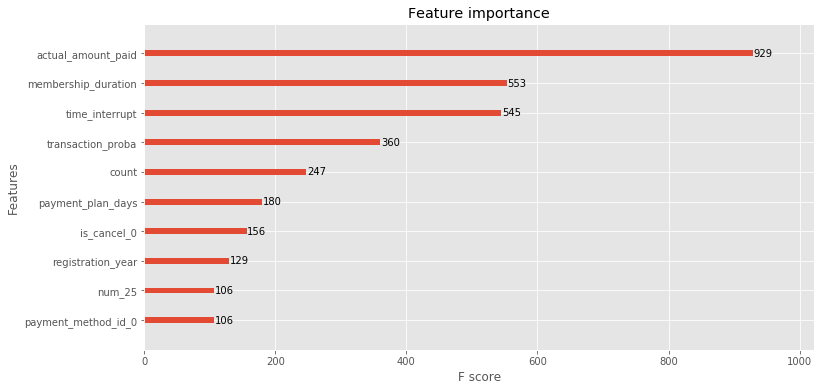

In [194]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb1, max_num_features=10, ax = ax)

### 2.7. Neural Network

In [222]:
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [196]:
model = Sequential()
model.add(Dense(50, activation = 'relu', input_shape = (30, )))
model.add(Dropout(0.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(80, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [197]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [200]:
model.fit(X, Y, batch_size = 128, epochs = 10, validation_data = (X_test, Y_test), verbose = 2)

Train on 970960 samples, validate on 907471 samples
Epoch 1/10
 - 23s - loss: 0.1341 - acc: 0.9491 - val_loss: 0.6204 - val_acc: 0.7008
Epoch 2/10
 - 23s - loss: 0.1158 - acc: 0.9550 - val_loss: 0.5857 - val_acc: 0.8044
Epoch 3/10
 - 23s - loss: 0.1117 - acc: 0.9564 - val_loss: 0.6708 - val_acc: 0.6496
Epoch 4/10
 - 23s - loss: 0.1101 - acc: 0.9569 - val_loss: 0.6561 - val_acc: 0.7084
Epoch 5/10
 - 24s - loss: 0.1092 - acc: 0.9575 - val_loss: 0.5791 - val_acc: 0.7472
Epoch 6/10
 - 23s - loss: 0.1083 - acc: 0.9576 - val_loss: 0.6773 - val_acc: 0.6626
Epoch 7/10
 - 23s - loss: 0.1076 - acc: 0.9578 - val_loss: 0.6379 - val_acc: 0.6274
Epoch 8/10
 - 23s - loss: 0.1070 - acc: 0.9579 - val_loss: 0.5466 - val_acc: 0.7758
Epoch 9/10
 - 23s - loss: 0.1062 - acc: 0.9583 - val_loss: 0.5384 - val_acc: 0.7798
Epoch 10/10
 - 23s - loss: 0.1056 - acc: 0.9584 - val_loss: 0.5712 - val_acc: 0.7083


In [109]:
Y_test = model.predict(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test.ravel()})
submission.to_csv('nn3.csv', index = False)

## 3. Stacking

In [224]:
from sklearn.model_selection import StratifiedKFold
def features_stacking(X, Y, X_test, model, cv = 4, name_model_as_feature = 'logistic', random_state = True):
    skf = StratifiedKFold(n_splits=cv, shuffle = True)
    # Create an empty dictionary to keep k-fold
    train_splits = {}
    # Loop for k-fold index to generate X_train, X_val, Y_train, Y_val of each fold
    for (i, (train_index, val_index)) in enumerate(skf.split(X, Y)):
        train_splits['Fold_' + str(i + 1)] = (train_index, val_index, X[train_index], X[val_index], Y[train_index], Y[val_index])
    # Create an empty DataFrame to keep features stacking of training data
    stacking_train = pd.DataFrame(columns = [name_model_as_feature])
    # Create an empty array to compute sum of probability of test data
    sum_proba_test = np.zeros(X_test.shape[0])
    # Loop for k_fold
    for i in range(cv):
        # Retrieve infomation of fold_i+1
        (train_index, val_index, X_train, X_val, Y_train, Y_val) = train_splits['Fold_' + str(i + 1)]
        # Set random_state for the model and fit
        if random_state:
            model.set_params(random_state = np.random.randint(2019))
        model.fit(X_train, Y_train)
        # Append results on X_val to stacking_train DataFrame
        stacking_train = pd.concat([stacking_train, pd.DataFrame(model.predict_proba(X_val)[:, 1], columns = [name_model_as_feature], index = val_index)], axis = 0)
        # Compute predict_proba of X_test
        sum_proba_test += model.predict_proba(X_test)[:, 1]
    # Reset index of stacking_train
    stacking_train = stacking_train.sort_index()
    # Create a DataFrame to keep stacking_test
    stacking_test = pd.DataFrame(data = sum_proba_test/cv, columns = [name_model_as_feature])
    return (stacking_train, stacking_test)

In [217]:
# Random Forest
model = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_leaf = 10)
randomforest = features_stacking(X, Y, X_test, model, cv = 4, name_model_as_feature = 'randomforest')

In [218]:
# Catboost
model = CatBoostClassifier(iterations=120, learning_rate=0.1, loss_function='CrossEntropy', 
                        custom_loss = 'Logloss', random_seed = 167, l2_leaf_reg=3, bagging_temperature=1, random_strength=1, 
                        one_hot_max_size=2, leaf_estimation_method='Newton')
cb = features_stacking(X, Y, X_test, model, cv = 4, name_model_as_feature = 'cb', random_state = False)

0:	learn: 0.4692097	total: 279ms	remaining: 33.2s
1:	learn: 0.3795942	total: 521ms	remaining: 30.8s
2:	learn: 0.3135115	total: 749ms	remaining: 29.2s
3:	learn: 0.2421535	total: 993ms	remaining: 28.8s
4:	learn: 0.1853727	total: 1.24s	remaining: 28.6s
5:	learn: 0.1643378	total: 1.49s	remaining: 28.2s
6:	learn: 0.1444512	total: 1.76s	remaining: 28.4s
7:	learn: 0.1314347	total: 1.98s	remaining: 27.7s
8:	learn: 0.1253807	total: 2.2s	remaining: 27.2s
9:	learn: 0.1174898	total: 2.44s	remaining: 26.8s
10:	learn: 0.1115741	total: 2.68s	remaining: 26.6s
11:	learn: 0.1074104	total: 2.92s	remaining: 26.3s
12:	learn: 0.1058054	total: 3.2s	remaining: 26.3s
13:	learn: 0.1031069	total: 3.47s	remaining: 26.2s
14:	learn: 0.1016330	total: 3.7s	remaining: 25.9s
15:	learn: 0.0993239	total: 3.92s	remaining: 25.5s
16:	learn: 0.0984292	total: 4.15s	remaining: 25.1s
17:	learn: 0.0974612	total: 4.39s	remaining: 24.9s
18:	learn: 0.0969290	total: 4.64s	remaining: 24.7s
19:	learn: 0.0959560	total: 4.87s	remaining:

42:	learn: 0.0874182	total: 9.85s	remaining: 17.6s
43:	learn: 0.0872687	total: 10.1s	remaining: 17.4s
44:	learn: 0.0871654	total: 10.3s	remaining: 17.2s
45:	learn: 0.0870214	total: 10.6s	remaining: 17s
46:	learn: 0.0868731	total: 10.8s	remaining: 16.8s
47:	learn: 0.0867465	total: 11.1s	remaining: 16.6s
48:	learn: 0.0865437	total: 11.3s	remaining: 16.4s
49:	learn: 0.0863670	total: 11.6s	remaining: 16.2s
50:	learn: 0.0862083	total: 11.8s	remaining: 16s
51:	learn: 0.0860669	total: 12.1s	remaining: 15.8s
52:	learn: 0.0859296	total: 12.3s	remaining: 15.6s
53:	learn: 0.0858145	total: 12.5s	remaining: 15.3s
54:	learn: 0.0857586	total: 12.8s	remaining: 15.1s
55:	learn: 0.0856294	total: 13s	remaining: 14.8s
56:	learn: 0.0854637	total: 13.2s	remaining: 14.6s
57:	learn: 0.0853681	total: 13.5s	remaining: 14.4s
58:	learn: 0.0852892	total: 13.7s	remaining: 14.1s
59:	learn: 0.0851315	total: 13.9s	remaining: 13.9s
60:	learn: 0.0850506	total: 14.1s	remaining: 13.7s
61:	learn: 0.0849362	total: 14.4s	rem

84:	learn: 0.0836279	total: 20.3s	remaining: 8.36s
85:	learn: 0.0835712	total: 20.6s	remaining: 8.13s
86:	learn: 0.0834576	total: 20.8s	remaining: 7.9s
87:	learn: 0.0833907	total: 21.1s	remaining: 7.67s
88:	learn: 0.0833480	total: 21.3s	remaining: 7.42s
89:	learn: 0.0832494	total: 21.6s	remaining: 7.19s
90:	learn: 0.0832043	total: 21.8s	remaining: 6.96s
91:	learn: 0.0831742	total: 22.1s	remaining: 6.71s
92:	learn: 0.0831035	total: 22.3s	remaining: 6.48s
93:	learn: 0.0830356	total: 22.6s	remaining: 6.26s
94:	learn: 0.0828521	total: 22.9s	remaining: 6.03s
95:	learn: 0.0827264	total: 23.2s	remaining: 5.8s
96:	learn: 0.0826292	total: 23.4s	remaining: 5.55s
97:	learn: 0.0825618	total: 23.7s	remaining: 5.31s
98:	learn: 0.0825270	total: 23.9s	remaining: 5.07s
99:	learn: 0.0824839	total: 24.2s	remaining: 4.83s
100:	learn: 0.0824365	total: 24.4s	remaining: 4.59s
101:	learn: 0.0824107	total: 24.6s	remaining: 4.34s
102:	learn: 0.0823692	total: 24.8s	remaining: 4.09s
103:	learn: 0.0823542	total: 2

In [220]:
# XGBoost
model = XGBClassifier(learning_rate = 0.1, n_estimators = 150, max_depth=5, min_child_weight=5, gamma=0, subsample=0.8,
                      colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb = features_stacking(X, Y, X_test, model, cv = 4, name_model_as_feature = 'xgb', random_state = False)

In [225]:
# Neural Network
model = MLPClassifier(hidden_layer_sizes = (50, 100, 80), alpha = 0.001, batch_size = 128, max_iter = 10)
nn = features_stacking(X, Y, X_test, model, cv = 4, name_model_as_feature = 'nn')

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code

In [226]:
stacking_train = pd.concat([randomforest[0], cb[0], xgb[0], nn[0]], axis = 1)
stacking_test = pd.concat([randomforest[1], cb[1], xgb[1], nn[1]], axis = 1)

In [229]:
clf = LogisticRegression()
clf.fit(stacking_train, Y)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [230]:
log_loss(Y, clf.predict_proba(stacking_train))

0.09259864825435275

In [231]:
log_loss(Y_test, clf.predict_proba(stacking_test))

0.3691638522667676

In [235]:
Y_test_stacked = clf.predict_proba(stacking_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test_stacked[:, 1].ravel()})
submission.to_csv('stack1.csv', index = False)

In [232]:
xgb1 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 150,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [233]:
xgb1.fit(stacking_train, Y, eval_metric = 'logloss', eval_set = [(stacking_test, Y_test)], early_stopping_rounds = 50, verbose = 50)

[0]	validation_0-logloss:0.664264
Will train until validation_0-logloss hasn't improved in 50 rounds.
[50]	validation_0-logloss:0.551337
[100]	validation_0-logloss:0.54494
Stopping. Best iteration:
[96]	validation_0-logloss:0.543352



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [234]:
cb1 = CatBoostClassifier(iterations=150, learning_rate=0.1, od_type='Iter', od_wait=50, loss_function='CrossEntropy', 
                        custom_loss = 'Logloss', random_seed = 167, l2_leaf_reg=3, bagging_temperature=1, random_strength=1, 
                        one_hot_max_size=2, leaf_estimation_method='Newton')
cb1.fit(stacking_train, Y, eval_set=(stacking_test, Y_test), verbose=50)

0:	learn: 0.4226236	test: 0.6691899	best: 0.6691899 (0)	total: 289ms	remaining: 43.1s
50:	learn: 0.0792276	test: 0.5337726	best: 0.5325972 (32)	total: 14s	remaining: 27.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5325971841
bestIteration = 32

Shrink model to first 33 iterations.


In [250]:
score = pd.read_csv('submission_scores.csv')

In [251]:
score

,Name,Date,Best Score,Comment
0,Van Anh,19-Jan,0.17540,Catboost
1,Van Anh,21-Jan,0.16270,Catboost ( Members and Transactions features)
2,Datcm,22-Jan,1.20000,Catboost (Members and userlogs features)
3,Van Anh,25-Jan,0.11990,Catboost
4,Van Anh,26-Jan,0.11700,Catboost
5,Thang Hoang,8-Feb,0.12747,"XGBoost (Members, Transactions and user_logs f..."


In [246]:
score = score.iloc[:5, :4]

In [240]:
score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
Name           5 non-null object
 Date          5 non-null object
 Best Score    5 non-null float64
 Comment       5 non-null object
dtypes: float64(1), object(3)
memory usage: 240.0+ bytes


In [248]:
score = score.append({'Name': 'Thang Hoang',
              ' Date': '8-Feb', 
              ' Best Score': 0.12747, 
              ' Comment': 'XGBoost (Members, Transactions and user_logs features)'}, ignore_index=True)

In [249]:
score.to_csv('submission_scores.csv', index = False)